In [1]:
import PyPDF2 as pdf
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nltk.util import ngrams

In [2]:
from collections import Counter, defaultdict
#import nltk for first step extracting words
import nltk
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem.wordnet import WordNetLemmatizer

#set up stop_words from nltk
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer() 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/viviankang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/viviankang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Import Data from PDF

In [3]:
def read_PDF(path):
    file = open(path,'rb')
    pdf_reader=pdf.PdfFileReader(file)
    txt=""
    for i in range(0,pdf_reader.getNumPages()):
        txt=txt+pdf_reader.getPage(i).extractText().replace('\n','')
    return txt

In [4]:
file_lst=os.listdir('PDF/')

In [5]:
txt_dict={}
for name in file_lst:
    m = re.match(r'^(monetary2020)(\d{4})(a1.pdf)$', name)
    txt_dict[m.group(2)]=read_PDF('PDF/'+name)

In [6]:
txt_dict.keys()

dict_keys(['1105', '0429', '0303', '0323', '0610', '0729', '1216', '0129', '0315', '0916'])

# Count references to Coronavirus

In [7]:
covid_lexicon=['coronavirus','virus','COVID-19','pandemic','ongoing public health crisis']

In [8]:
covid_dict={}
for key in sorted(txt_dict.keys()):
    num=0
    for name in covid_lexicon:
        expression=r'\b'+name+r'\b'
        lst=re.findall(expression, txt_dict[key], flags=0)
        num=num+len(lst)
    covid_dict[key]=num

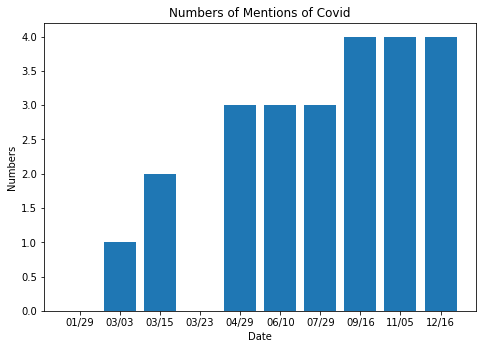

In [9]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x=[]
y=[]
for date in covid_dict.keys():
    m = re.match(r'^(\d{2})(\d{2})$', date)
    x.append(m.group(1)+'/'+m.group(2))
    y.append(covid_dict[date])
ax.bar(x,y)
plt.title('Numbers of Mentions of Covid')
plt.xlabel('Date')
plt.ylabel('Numbers')
plt.show()

# Classification of  FOMC Statement as Hawkish versus Dovish 
##### Method 1: With manually assigned levels for customized dictionaries of phrases, the level for the document is the average of the level of each word contained in the library.
##### Method 2: With customized dictionaries containing only single words, the tf-idf weight is used to evaluate each document just as what we did for the financial statements.
##### Method 3: Combining the previous two methods, dictionaries of phrases are used while the weight is based on tf-idf instead of being assigned manually.

### Method 1: Dictionaries of Phrases + Manually Assigned Weights

In [10]:
# Loading Dictionaries of Phrases
df_H=pd.read_excel('dict.xlsx',sheet_name='Hawkish_Phrases',header=0)
df_D=pd.read_excel('dict.xlsx',sheet_name='Dovish_Phrases',header=0)
df_phrases=pd.concat([df_H,df_D])

In [11]:
#P arse text and convert to a list of words
def parse_txt2word(txt):
    # Removing all punctuation marks and non characters
    txt = re.sub(r'\W+', ' ', txt)
    # Converting into lowercase
    txt = txt.lower()
    # Removing numbers from string
    txt = re.sub(r'\d','',txt)
    # Removing all single characters
    txt = re.sub(r'\b(?<=)[a-z](?=)\b', ' ', txt)
    # Removing all extra spaces
    txt = re.sub(r'\s+', ' ', txt)
    #convert plurals and time
    txt = [lemmatizer.lemmatize(word, pos = 'v') for word in txt.split(' ') if word not in stop_words and word!=""]
    #txt = [lemmatizer.lemmatize(word, pos = 'n') for word in txt if word not in stop_words]
    return txt   

In [12]:
df_phrases['Pharses']=df_phrases['Pharses'].apply(parse_txt2word)
df_phrases['Pharses']=df_phrases['Pharses'].apply(tuple)
df_phrases.head()

,Pharses,Level
0,"(labor, market, remain, strong)",-3
1,"(economic, activity, rise)",-5
2,"(job, gain, solid)",-3
3,"(unemployment, rate, remain, low)",-3
4,"(inflation, compensation, remain, low)",-3


In [13]:
# Find the n gram phrases in each document and find the corresponding levels
lst_dict={}
ngrams_dict={} # Storing the n gram phrases, will be used in method 3
for i in range(1,5):
    for date in sorted(txt_dict.keys()): 
        s = txt_dict[date]
        s = parse_txt2word(s)
        phrase_lst = list(ngrams(s, i))
        ngrams_dict[date]=ngrams_dict[date]+phrase_lst if date in ngrams_dict.keys() else phrase_lst
        lst=[int(df_phrases.loc[df_phrases['Pharses'] == phrase,"Level"]) for phrase in phrase_lst if phrase in set(df_phrases.Pharses)]
        #print([df_phrases.loc[df_phrases['Pharses'] == phrase] for phrase in phrase_lst if phrase in set(df_phrases.Pharses)])
        lst_dict[date]=lst_dict[date]+lst if date in lst_dict.keys() else lst        

In [14]:
# Averaging the levels and ranging them
scores=[]
for date in sorted(lst_dict.keys()):
    scores.append(sum(lst_dict[date])/len(lst_dict[date]))
ranged_scores=[int(9*(score-min(scores))/(max(scores)-min(scores)))+1 for score in scores]

In [15]:
ranged_scores

[1, 7, 5, 6, 10, 8, 7, 6, 7, 7]

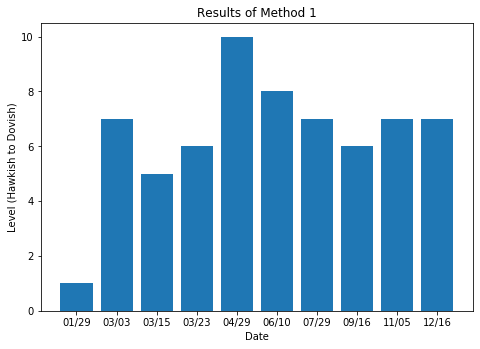

In [16]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x=[]
y=[]
for i,date in enumerate(sorted(txt_dict.keys())):
    m = re.match(r'^(\d{2})(\d{2})$', date)
    x.append(m.group(1)+'/'+m.group(2))
    y.append(ranged_scores[i])
ax.bar(x,y)
plt.title('Results of Method 1')
plt.xlabel('Date')
plt.ylabel('Level (Hawkish to Dovish)')
plt.show()

### Method 2: Dictionaries of Single Words + TF-IDF Weights

In [17]:
# Single word dictionaries
H_words=["strong","rise","solid","foster","moderate","improve","increase","accommodative"]
D_words=["low","risk","challenging","weather","lower","harm","disrupt","strain","decrease",
         "hardship","surge","disruption","impair"]

In [18]:
#define a function to remove punctuations if a given word ended with a punctuation
def remove_punct(string):
    return re.sub(r"[{}]+".format(punctuation), "", string)

#define a function for filtering words
def filter_words(string):
    return bool(re.match(r'^[a-z\']+$', string))

def Process_txt(txt):
    #remove the punct
    txt = txt_dict[date]
    txt = [remove_punct(word) for word in txt.split() if word not in stop_words]
        
    #just reserve all the words
    txt = list(filter(filter_words, txt))
        
    #convert plurals and time
    txt = [lemmatizer.lemmatize(word, pos = 'v') for word in txt if word not in stop_words]
    txt = [lemmatizer.lemmatize(word, pos = 'n') for word in txt if word not in stop_words]
        
    #do the counter to translate to a dict
    txt = Counter(txt)
    return txt

In [19]:
#iterate through all the documents 
txt_words_dicts={}
for date in sorted(txt_dict.keys()):
    #process the txt
    txt_words_dicts[date]=Process_txt(txt_dict[date])

In [20]:
"""
This part is to compute the tf values for the words in FOMC and collect the overall word list for computing idf in the next step
"""
#count the number of  documents we have
document_num_FOMC = 0

#word list for FOMC 
word_list_FOMC = defaultdict(int)


for date in sorted(txt_dict.keys()):        
#iterate through the words in tf, which is the words of a given  document of a given date
    document_num_FOMC+=1
    for word in txt_words_dicts[date].keys():
    #add one if it already contains the word, or add the this word to the dict if not
        word_list_FOMC[word] += txt_words_dicts[date][word]
        

In [21]:
#compute idf value for the word in 10ks
idf_FOMC = {}

#iterate through all the words in word_list_10k
for word in word_list_FOMC:
    
    #compute idf value
    idf_FOMC[word] = np.log(document_num_FOMC / (1 + word_list_FOMC[word]))

In [22]:
tfidf_dict={}
for date in sorted(txt_dict.keys()):  
    #number of total words
    word_num = len(txt_dict[date])
        
    #average number of all the words
    word_avg = len(txt_words_dicts[date])/len(txt_dict[date])
    #np.mean(list(all_data[ticker][date].values()))
        
    #set up a dictionary storing tf_value and tf-idf_value
    temp_dictionary = {'tf':{},'tf_idf':{}}
        
    #iterate through all the word
    for word, num in txt_words_dicts[date].items():
            
        #compute tf values
        temp_dictionary['tf'][word] = num / word_num
            
        #compute tf_idf_values
        temp_dictionary['tf_idf'][word] = (1 + np.log(num)) / (1 + np.log(word_avg)) * idf_FOMC[word]
        
        #substitute the temp_dictionary to the orignal dict
        tfidf_dict[date] = temp_dictionary

In [23]:
data={}
for date in sorted(txt_dict.keys()):
    data[date]={}
#calculate tf-idf sum using dictionary1 and store
    data[date]['Hawk'] = sum([tfidf_dict[date]['tf_idf'][word] for word in tfidf_dict[date]['tf_idf'] 
                            if word in H_words])
         
#calculate tf-idf sum using dictionary2 and store
    data[date]['Dov'] = sum([tfidf_dict[date]['tf_idf'][word] for word in tfidf_dict[date]['tf_idf'] 
                             if word in D_words]) 
    
    data[date]['Score'] = data[date]['Hawk']-data[date]['Dov']
        
        

In [24]:
scores=[data[date]['Score'] for date in sorted(txt_dict.keys())]
ranged_scores=[int(9*(data[date]['Score']-min(scores))/(max(scores)-min(scores)))+1 for date in sorted(txt_dict.keys())]

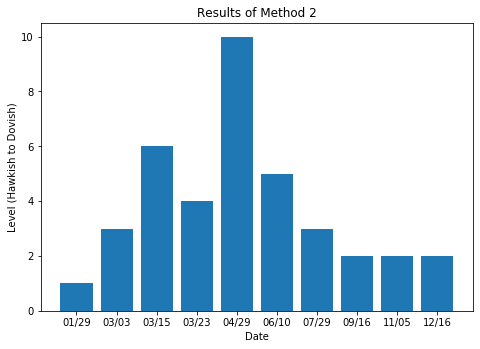

In [25]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x=[]
y=[]
for i,date in enumerate(sorted(txt_dict.keys())):
    m = re.match(r'^(\d{2})(\d{2})$', date)
    x.append(m.group(1)+'/'+m.group(2))
    y.append(ranged_scores[i])
ax.bar(x,y)
plt.title('Results of Method 2')
plt.xlabel('Date')
plt.ylabel('Level (Hawkish to Dovish)')
plt.show()

### Method 3: Dictionaries of Phrases + TF-IDF Weights

In [26]:
ngrams_dict_count={}
for date in sorted(txt_dict.keys()):
    ngrams_dict_count[date]=Counter(ngrams_dict[date])

In [27]:
# tf values containing phrases
#count the number of  documents we have
document_num_FOMC = 10

#word list for 10k 
phrase_list_FOMC = defaultdict(int)

for i in range(1,5):
    for date in sorted(txt_dict.keys()):
        document_num_FOMC+=1
        for phrase in ngrams_dict_count[date].keys():
        #add one if it already contains the word, or add the this word to the dict if not
            phrase_list_FOMC[phrase] += ngrams_dict_count[date][phrase]

In [28]:
#compute idf value for the word in 10ks
phrase_idf_FOMC = {}

#iterate through all the words in word_list_10k
for phrase in phrase_list_FOMC:
    
    #compute idf value
    phrase_idf_FOMC[phrase] = np.log(document_num_FOMC / (1 + phrase_list_FOMC[phrase]))

In [29]:
phrase_tfidf_dict={}
for date in sorted(txt_dict.keys()):  
    #number of total words
    word_num = len(ngrams_dict[date])
        
    #average number of all the words
    word_avg = len(ngrams_dict[date])/len(ngrams_dict_count[date])
    #np.mean(list(all_data[ticker][date].values()))
        
    #set up a dictionary storing tf_value and tf-idf_value
    temp_dictionary = {'tf':{},'tf_idf':{}}
        
    #iterate through all the word
    for phrase, num in ngrams_dict_count[date].items():
            
        #compute tf values
        temp_dictionary['tf'][phrase] = num / word_num
            
        #compute tf_idf_values
        temp_dictionary['tf_idf'][phrase] = (1 + np.log(num)) / (1 + np.log(word_avg)) * phrase_idf_FOMC[phrase]
        
        #substitute the temp_dictionary to the orignal dict
        phrase_tfidf_dict[date] = temp_dictionary

In [30]:
data={}
for date in sorted(txt_dict.keys()):
    data[date]={}
#calculate tf-idf sum using dictionary1 and store
    data[date]['Hawk'] = sum([phrase_tfidf_dict[date]['tf_idf'][phrase] for phrase in phrase_tfidf_dict[date]['tf_idf'] 
                            if phrase in set(df_phrases.loc[df_phrases["Level"]<0,"Pharses"])])
         
#calculate tf-idf sum using dictionary2 and store
    data[date]['Dov'] = sum([phrase_tfidf_dict[date]['tf_idf'][phrase] for phrase in phrase_tfidf_dict[date]['tf_idf'] 
                             if phrase in set(df_phrases.loc[df_phrases["Level"]>0,"Pharses"])]) 
    
    data[date]['Score'] = -data[date]['Hawk']+data[date]['Dov']
        

In [31]:
scores=[data[date]['Score'] for date in sorted(txt_dict.keys())]

In [32]:
ranged_scores=[int(9*(data[date]['Score']-min(scores))/(max(scores)-min(scores)))+1 for date in sorted(txt_dict.keys())]

In [33]:
ranged_scores

[1, 6, 4, 5, 10, 8, 7, 6, 7, 7]

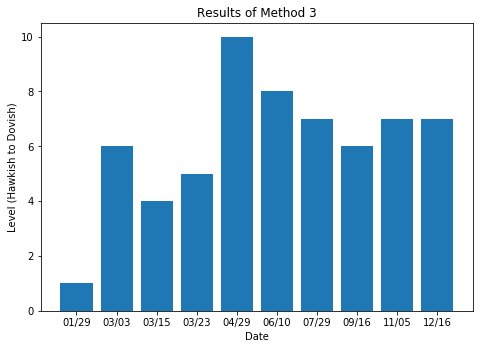

In [34]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x=[]
y=[]
for i,date in enumerate(sorted(txt_dict.keys())):
    m = re.match(r'^(\d{2})(\d{2})$', date)
    x.append(m.group(1)+'/'+m.group(2))
    y.append(ranged_scores[i])
ax.bar(x,y)
plt.title('Results of Method 3')
plt.xlabel('Date')
plt.ylabel('Level (Hawkish to Dovish)')
plt.show()

### Conclusion
It seems that the result of method 2 complies with the expectation most. The most hawkish document is the January one while the most dovish document is the April one. For the result of method 2, the recent months have gone less dovish while for the result of other two methods, the recent months have remained quite dovish. This might be because the dictionaries of phrases have based on lots of mentions of influence caused by covid-19. Indeed, the mentions of covid-19 have grown recently as the previous section shows. This have caused these months to appear pretty dovish.